In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

In [35]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import folium
%matplotlib inline

### 讀取資料 Load Data

#### 捷運路線每日分時旅次: 201901-202106

In [3]:
routes_counts = pd.read_csv('./Data/Taipei_Metro_Route_hourly_2019-202106.csv')

In [4]:
routes_counts['Date'] = pd.to_datetime(routes_counts['Date'])
routes_counts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252135281 entries, 0 to 252135280
Data columns (total 5 columns):
 #   Column    Dtype         
---  ------    -----         
 0   Date      datetime64[ns]
 1   Hour      int64         
 2   Entrance  object        
 3   Exit      object        
 4   Counts    int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 9.4+ GB


#### 捷運站資料

In [5]:
stations = pd.read_csv('./Data/Taipei_Metro_Stations_geo.csv')
stations.head()

,Code,Station,Line,Line2,Cross_Lines,Lines_Transfer,Transportation,station_name_en,address,lat,lon
0,BL01,頂埔,BL,N,0,0,0,Dingpu,新北市土城區中央路四段51-6號B3,24.960120,121.420500
1,BL02,永寧,BL,N,0,0,0,Yongning,新北市土城區中央路三段105號B1,24.966726,121.436072
2,BL03,土城,BL,N,0,0,0,Tucheng,新北市土城區金城路一段105號B1,24.973094,121.444362
3,BL04,海山,BL,N,0,0,0,Haishan,新北市土城區海山路39號B2,24.985339,121.448786
4,BL05,亞東醫院,BL,N,0,0,0,Far Eastern Hospital,新北市板橋區南雅南路二段17號B1,24.998037,121.452514


In [6]:
stationmap = {name: stations.at[i,'Code'] for i, name in stations['Station'].items()}

#### 捷運站各路線車程時間

In [7]:
traveltime = pd.read_csv('./Data/Taipei_Metro_Route_Traveltime_v2.csv')
traveltime = traveltime.drop_duplicates().reset_index(drop=True)
traveltime['DrivingTime'] = traveltime['DrivingTime(s)']/60
traveltime.tail()

,StationA,StationB,Code_StationA,Code_StationB,From_To,TravelTime,From_lat,From_lon,To_lat,To_lon,DrivingTime(s),Distance(m),DrivingTime
14037,新北產業園區,中原,Y20,Y14,Y20_Y14,17,25.061548,121.459926,25.008410,121.484159,853,7526,14.216667
14038,新北產業園區,板新,Y20,Y15,Y20_Y15,14,25.061548,121.459926,25.014491,121.472212,743,5664,12.383333
14039,新北產業園區,Y板橋,Y20,Y16,Y20_Y16,11,25.061548,121.459926,25.015156,121.464825,834,5833,13.900000
14040,新北產業園區,新埔民生,Y20,Y17,Y20_Y17,8,25.061548,121.459926,25.026125,121.466839,542,4217,9.033333
14041,新北產業園區,幸福,Y20,Y19,Y20_Y19,3,25.061548,121.459926,25.050282,121.460216,360,1667,6.000000


# COVID-19發生後，仍有通勤需求的高流量搭乘路線與捷運進站

* 2020/01/22臺灣首例確認個案
* 2021/05/11政府提升全國疫情警戒至第二級，05/15雙北地區警戒提升至第三級，5/19全國警戒提升至第三級，日旅運量當月起大幅下降。

## Data Process

In [8]:
def get_groupby_route(df):
    output = df.pivot_table(values='Counts', index=['Date','Hour','Entrance','Exit'], aggfunc=np.sum).reset_index()
    output['DayofWeek'] = output['Date'].dt.dayofweek
    output['Weekend'] = output['DayofWeek'].isin([5,6])
    return output

In [9]:
def get_condition_df(df):
    #每日分時平均旅次的路線
    routes = df.pivot_table(values='Counts', index=['Entrance','Exit'], aggfunc=np.mean).reset_index().sort_values(by='Counts', ascending=False).reset_index(drop=True)
    #平日高於假日之每日分時平均旅次的路線
    data = df.pivot_table(values='Counts', index=['Entrance','Exit'], columns=['Weekend'], aggfunc=np.mean).reset_index().rename(columns={False:'Normal', True:'Weekend'})
    data['Diff'] = data['Normal'] - data['Weekend']
    data['From_To'] = data['Entrance'].map(stationmap) + '_' + data['Exit'].map(stationmap)
    normal_routes = data.sort_values(by='Diff', ascending=False).reset_index(drop=True)
    #進站次數前10名捷運站
    stations = pd.DataFrame(df.groupby('Entrance')['Counts'].sum()).reset_index().sort_values(by='Counts', ascending=False).reset_index(drop=True)
    #平日高於假日進站次數前10名捷運站
    data = df.pivot_table(values='Counts', index='Entrance', columns='Weekend', aggfunc=np.mean).reset_index().rename(columns={False:'Normal', True:'Weekend'})
    data['Diff'] = data['Normal'] - data['Weekend']
    data = data.sort_values(by='Diff', ascending=False).reset_index(drop=True)
    stationlist = set(np.append(stations[:10]['Entrance'].values, data[:10]['Entrance'].values, axis=0))

    return routes, normal_routes, stationlist

In [10]:
def get_comparison_df(before, after):
    after = after.pivot_table(values='Counts', index=['Entrance','Exit'], aggfunc=np.mean).reset_index().sort_values(by='Counts', ascending=False).reset_index(drop=True)
    data = before.merge(after, how='inner', on=['Entrance','Exit'], suffixes=['_before','_after'])
    data['Diff_ratio'] = (data['Counts_after'] - data['Counts_before']) / data['Counts_before']
    data['From_To'] = data['Entrance'].map(stationmap) + '_' + data['Exit'].map(stationmap)
    return data

#### COVID-19前: 2019年

In [11]:
morn = routes_counts[(routes_counts['Date'] < datetime.strptime('2020-01-01','%Y-%m-%d')) & (routes_counts['Hour'].isin([7,8,9]))]
even = routes_counts[(routes_counts['Date'] < datetime.strptime('2020-01-01','%Y-%m-%d')) & (routes_counts['Hour'].isin([17,18,19]))]

In [12]:
morning_routes, morning_normal_routes, morning_stationlist = get_condition_df(get_groupby_route(morn))

In [13]:
evening_routes, evening_normal_routes, evening_stationlist = get_condition_df(get_groupby_route(even))

In [14]:
morning_routes.head(3)

,Entrance,Exit,Counts
0,台北車站,市政府,388.832877
1,台北車站,台北101/世貿,347.145205
2,台北車站,中正紀念堂,321.136073


In [15]:
evening_routes.head(3)

,Entrance,Exit,Counts
0,市政府,台北車站,698.573516
1,台北車站,西門,686.257534
2,西門,台北車站,678.787215


#### 雙北三級警戒後: 2021/5/15~2021/6/30

In [16]:
morn = routes_counts[(routes_counts['Date'] >= datetime.strptime('2021-05-15','%Y-%m-%d')) & (routes_counts['Hour'].isin([7,8,9]))]
even = routes_counts[(routes_counts['Date'] >= datetime.strptime('2021-05-15','%Y-%m-%d')) & (routes_counts['Hour'].isin([17,18,19]))]

In [17]:
morning_comp = get_comparison_df(morning_routes, get_groupby_route(morn))
morning_comp.head()

,Entrance,Exit,Counts_before,Counts_after,Diff_ratio,From_To
0,台北車站,市政府,388.832877,92.148936,-0.763011,BL12_BL18
1,台北車站,台北101/世貿,347.145205,47.226950,-0.863956,BL12_R03
2,台北車站,中正紀念堂,321.136073,81.319149,-0.746777,BL12_G10
3,西門,台北車站,291.414612,18.099291,-0.937892,BL11_BL12
4,新埔,市政府,286.864840,77.865248,-0.728565,BL08_BL18


In [18]:
evening_comp = get_comparison_df(evening_routes, get_groupby_route(even))
evening_comp.head()

,Entrance,Exit,Counts_before,Counts_after,Diff_ratio,From_To
0,市政府,台北車站,698.573516,85.085106,-0.878202,BL18_BL12
1,台北車站,西門,686.257534,27.914894,-0.959323,BL12_BL11
2,西門,台北車站,678.787215,44.163121,-0.934938,BL11_BL12
3,台北101/世貿,台北車站,587.787215,46.652482,-0.920630,R03_BL12
4,淡水,台北車站,443.509589,21.170213,-0.952267,R28_BL12


In [19]:
morning_comp.describe()

,Counts_before,Counts_after,Diff_ratio
count,11664.000000,11664.000000,11664.000000
mean,12.419267,3.565371,-0.682282
std,23.130870,6.530272,0.380599
min,0.001826,0.000000,-1.000000
25%,1.399087,0.375887,-0.801696
50%,4.518265,1.269504,-0.716782
75%,13.310274,3.723404,-0.628106
max,388.832877,93.503546,22.297872


In [20]:
evening_comp.describe()

,Counts_before,Counts_after,Diff_ratio
count,11664.000000,11664.000000,11664.000000
mean,16.423314,3.458256,-0.760397
std,32.844614,6.175751,0.178033
min,0.010046,0.000000,-1.000000
25%,1.931507,0.397163,-0.867361
50%,6.395434,1.326241,-0.788367
75%,17.650457,3.680851,-0.689445
max,698.573516,85.085106,5.571195


## 目標路線與捷運站

* 通勤期間平均時旅次高的路線中，在COVID-19之後時旅次為前10名路線
* 通勤期間平日平均時旅次遠於假日的前10名路線
* 若開車其行駛時間不大於20分鐘之路線
* 路線起站為通勤期間進站次數前10名或平日進站次數高於假日前10名之捷運站

In [21]:
def get_target_routes(df, normal_routes, stationlist):
    target_routes = pd.concat([df.sort_values(by=['Counts_after'], ascending=False).head(10), df[df['From_To'].isin(normal_routes['From_To'][:10])]]).drop_duplicates().reset_index(drop=True)
    target_routes = target_routes.merge(traveltime[['From_To','TravelTime','DrivingTime','From_lat','From_lon','To_lat','To_lon']], how='left', on=['From_To'])
    target_routes = target_routes[target_routes['DrivingTime'] <= 20]
    target_routes = target_routes[target_routes['Entrance'].isin(stationlist)].reset_index(drop=True)
    return target_routes

In [22]:
morning_target = get_target_routes(morning_comp, morning_normal_routes, morning_stationlist)
morning_target

,Entrance,Exit,Counts_before,Counts_after,Diff_ratio,From_To,TravelTime,DrivingTime,From_lat,From_lon,To_lat,To_lon
0,台北車站,市政府,388.832877,92.148936,-0.763011,BL12_BL18,11,14.583333,25.046255,121.517532,25.041171,121.565228
1,台北車站,中正紀念堂,321.136073,81.319149,-0.746777,BL12_G10,4,9.266667,25.046255,121.517532,25.032729,121.518270
2,新埔,台北車站,239.723288,71.751773,-0.700689,BL08_BL12,10,19.216667,25.023738,121.468361,25.046255,121.517532
3,頂溪,松江南京,206.676712,70.226950,-0.660209,O04_G15,13,11.783333,25.013821,121.515485,25.052015,121.533075
4,永安市場,松江南京,182.177169,60.709220,-0.666757,O03_G15,15,16.516667,25.002876,121.511231,25.052015,121.533075


In [23]:
evening_target = get_target_routes(evening_comp, evening_normal_routes, evening_stationlist)
evening_target

,Entrance,Exit,Counts_before,Counts_after,Diff_ratio,From_To,TravelTime,DrivingTime,From_lat,From_lon,To_lat,To_lon
0,市政府,台北車站,698.573516,85.085106,-0.878202,BL18_BL12,11,13.233333,25.041171,121.565228,25.046255,121.517532
1,南京復興,松山,242.740639,79.482270,-0.672563,BR11_G19,7,13.983333,25.052319,121.544011,25.050118,121.577706
2,市政府,新埔,249.720548,76.624113,-0.693161,BL18_BL08,21,18.933333,25.041171,121.565228,25.023738,121.468361
3,台北車站,新埔,291.708676,71.460993,-0.755026,BL12_BL08,10,13.133333,25.046255,121.517532,25.023738,121.468361
4,市政府,南港,292.695890,66.014184,-0.774462,BL18_BL22,8,14.200000,25.041171,121.565228,25.052116,121.606686
5,台北小巨蛋,松山,255.980822,64.865248,-0.746601,G17_G19,5,15.300000,25.051836,121.551530,25.050118,121.577706
6,南京三民,松山,238.345205,64.063830,-0.731214,G18_G19,3,8.983333,25.051652,121.564708,25.050118,121.577706
7,松江南京,頂溪,188.200913,63.666667,-0.661709,G15_O04,13,15.000000,25.052015,121.533075,25.013821,121.515485
8,松江南京,松山,199.372603,61.992908,-0.689060,G15_G19,9,16.450000,25.052015,121.533075,25.050118,121.577706
9,大安,台北車站,280.499543,40.453901,-0.855779,BR09_BL12,10,12.833333,25.032943,121.543551,25.046255,121.517532


加上疫情後時平均人旅次大於60

In [24]:
evening_target = evening_target[evening_target['Counts_after'] > 60]
evening_target

,Entrance,Exit,Counts_before,Counts_after,Diff_ratio,From_To,TravelTime,DrivingTime,From_lat,From_lon,To_lat,To_lon
0,市政府,台北車站,698.573516,85.085106,-0.878202,BL18_BL12,11,13.233333,25.041171,121.565228,25.046255,121.517532
1,南京復興,松山,242.740639,79.482270,-0.672563,BR11_G19,7,13.983333,25.052319,121.544011,25.050118,121.577706
2,市政府,新埔,249.720548,76.624113,-0.693161,BL18_BL08,21,18.933333,25.041171,121.565228,25.023738,121.468361
3,台北車站,新埔,291.708676,71.460993,-0.755026,BL12_BL08,10,13.133333,25.046255,121.517532,25.023738,121.468361
4,市政府,南港,292.695890,66.014184,-0.774462,BL18_BL22,8,14.200000,25.041171,121.565228,25.052116,121.606686
5,台北小巨蛋,松山,255.980822,64.865248,-0.746601,G17_G19,5,15.300000,25.051836,121.551530,25.050118,121.577706
6,南京三民,松山,238.345205,64.063830,-0.731214,G18_G19,3,8.983333,25.051652,121.564708,25.050118,121.577706
7,松江南京,頂溪,188.200913,63.666667,-0.661709,G15_O04,13,15.000000,25.052015,121.533075,25.013821,121.515485
8,松江南京,松山,199.372603,61.992908,-0.689060,G15_G19,9,16.450000,25.052015,121.533075,25.050118,121.577706


In [25]:
morning_target['Entrance'].unique()

array(['台北車站', '新埔', '頂溪', '永安市場'], dtype=object)

In [26]:
evening_target['Entrance'].unique()

array(['市政府', '南京復興', '台北車站', '台北小巨蛋', '南京三民', '松江南京'], dtype=object)

In [28]:
#morning_target.to_csv('./morning_target_routes.csv', index=False)
#evening_target.to_csv('./evening_target_routes.csv', index=False)

## 與Kmeans分類結果比較

In [29]:
route_kmean_result = pd.read_csv('route_kmean_result.csv')
station_kmean_result = pd.read_csv('station_kmean_result.csv')

#### cluster_label == 1

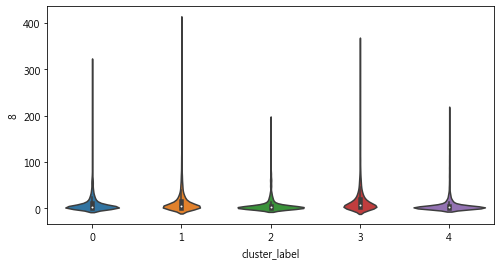

In [37]:
fig = plt.figure(figsize=(8,4))
sns.violinplot(x=route_kmean_result['cluster_label'], y=route_kmean_result.loc[:,'8'])
plt.show()

In [38]:
morning_route_kmean = route_kmean_result[route_kmean_result['cluster_label'] == 1].sort_values(by='8', ascending=False)[['StationA','StationB']].head(10)
morning_route_kmean['From_To'] = morning_route_kmean['StationA'].map(stationmap) + '_' + morning_route_kmean['StationB'].map(stationmap)
morning_route_kmean.head()

,StationA,StationB,From_To
3473,台北車站,市政府,BL12_BL18
3453,台北車站,台北101/世貿,BL12_R03
11202,頂溪,松江南京,O04_G15
6559,新埔,台北車站,BL08_BL12
2876,南港展覽館,西湖,BL23_BR16


In [39]:
morning_target[morning_target['From_To'].isin(morning_route_kmean['From_To'])]

,Entrance,Exit,Counts_before,Counts_after,Diff_ratio,From_To,TravelTime,DrivingTime,From_lat,From_lon,To_lat,To_lon
0,台北車站,市政府,388.832877,92.148936,-0.763011,BL12_BL18,11,14.583333,25.046255,121.517532,25.041171,121.565228
2,新埔,台北車站,239.723288,71.751773,-0.700689,BL08_BL12,10,19.216667,25.023738,121.468361,25.046255,121.517532
3,頂溪,松江南京,206.676712,70.226950,-0.660209,O04_G15,13,11.783333,25.013821,121.515485,25.052015,121.533075
4,永安市場,松江南京,182.177169,60.709220,-0.666757,O03_G15,15,16.516667,25.002876,121.511231,25.052015,121.533075


#### cluster_label == 3

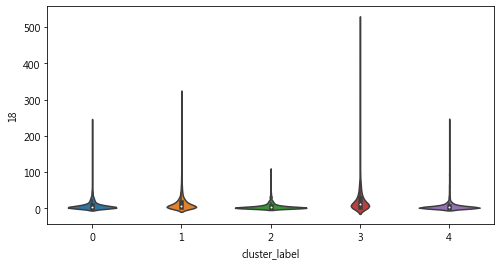

In [40]:
fig = plt.figure(figsize=(8,4))
sns.violinplot(x=route_kmean_result['cluster_label'], y=route_kmean_result.loc[:,'18'])
plt.show()

In [41]:
evening_route_kmean = route_kmean_result[route_kmean_result['cluster_label'] == 3].sort_values(by='18', ascending=False)[['StationA','StationB']].head(10)
evening_route_kmean['From_To'] = evening_route_kmean['StationA'].map(stationmap) + '_' + evening_route_kmean['StationB'].map(stationmap)
evening_route_kmean.head()

,StationA,StationB,From_To
5382,市政府,台北車站,BL18_BL12
10304,西門,台北車站,BL11_BL12
3134,台北101/世貿,台北車站,R03_BL12
3519,台北車站,西門,BL12_BL11
6024,忠孝敦化,台北車站,BL16_BL12


In [42]:
evening_target[evening_target['From_To'].isin(evening_route_kmean['From_To'])]

,Entrance,Exit,Counts_before,Counts_after,Diff_ratio,From_To,TravelTime,DrivingTime,From_lat,From_lon,To_lat,To_lon
0,市政府,台北車站,698.573516,85.085106,-0.878202,BL18_BL12,11,13.233333,25.041171,121.565228,25.046255,121.517532
1,南京復興,松山,242.740639,79.482270,-0.672563,BR11_G19,7,13.983333,25.052319,121.544011,25.050118,121.577706
4,市政府,南港,292.695890,66.014184,-0.774462,BL18_BL22,8,14.200000,25.041171,121.565228,25.052116,121.606686


# MAP

In [50]:
(morning_target.at[0,'From_lat'], morning_target.at[0,'From_lon']), (morning_target.at[0,'To_lat'], morning_target.at[0,'To_lon'])

((25.046255, 121.517532), (25.041171, 121.565228))

In [47]:
def get_od(df):
    od = []
    for i in df.index:
        xy = [(df.at[i,'From_lat'], df.at[i,'From_lon']), (df.at[i,'To_lat'], df.at[i,'To_lon'])]
        od.append(xy)
    return od

In [51]:
morning_target['OD'] = get_od(morning_target)
evening_target['OD'] = get_od(evening_target)

C:\Users\angel\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [54]:
stations[stations['Station'] == '台北車站'][['lat','lon']]

,lat,lon
11,25.046255,121.517532


In [55]:
colormap = [mcolors.to_hex(i) for i in plt.get_cmap().colors[::30][:len(morning_target)+1]]
#colormap = list(mcolors.TABLEAU_COLORS.values())[:len(morning_target)+1]

m_map = folium.Map(location=[25.046255,121.517532], zoom_start=13) #tiles=' Stamen Terrain')

for i in morning_target.index:
    folium.PolyLine(locations=morning_target.at[i,'OD'], color=colormap[i], weight=8, fill_opacity=0.6).add_to(m_map)
    folium.Marker(location=[morning_target.at[i,'From_lat'],morning_target.at[i,'From_lon']], 
                  popup=morning_target.at[i,'Entrance'], marker_color=colormap[i]).add_to(m_map)
    folium.CircleMarker(location=[morning_target.at[i,'From_lat'],morning_target.at[i,'From_lon']], 
                        color=colormap[i], radius=(22-i*2), fill=True, fill_opacity=0.5).add_to(m_map)
    #folium.Circle(location=[data.at[i,'To_lat'],data.at[i,'To_lon']], color=colormap[i], fill=True).add_to(m)
m_map

In [57]:
colormap = [mcolors.to_hex(i) for i in plt.get_cmap().colors[::20][:len(evening_target)+1]]
e_map = folium.Map(location=[25.046255,121.517532], zoom_start=13)

for i in evening_target.index:
    folium.PolyLine(locations=evening_target.at[i,'OD'], color=colormap[i], weight=6).add_to(e_map)
    folium.Marker(location=[evening_target.at[i,'From_lat'],evening_target.at[i,'From_lon']], 
                  popup=evening_target.at[i,'Entrance'], marker_color=colormap[i]).add_to(e_map)
    folium.CircleMarker(location=[evening_target.at[i,'From_lat'],evening_target.at[i,'From_lon']], 
                        color=colormap[i], radius=(26-i*2), fill=True, fill_opacity=0.8).add_to(e_map)
    #folium.Circle(location=[data.at[i,'To_lat'],data.at[i,'To_lon']], color=colormap[i], fill=True).add_to(m)    
e_map

In [58]:
m_map.save('morning_target_routes_map.html')

In [59]:
e_map.save('evening_target_routes_map.html')